In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## import packages

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

## load and understand data

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
# SibSp --> siblings or spouses
# unique(), nunique(), value_counts()
# string includes numbers and alphabets --> alphanumeric
train_data.shape

(891, 12)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


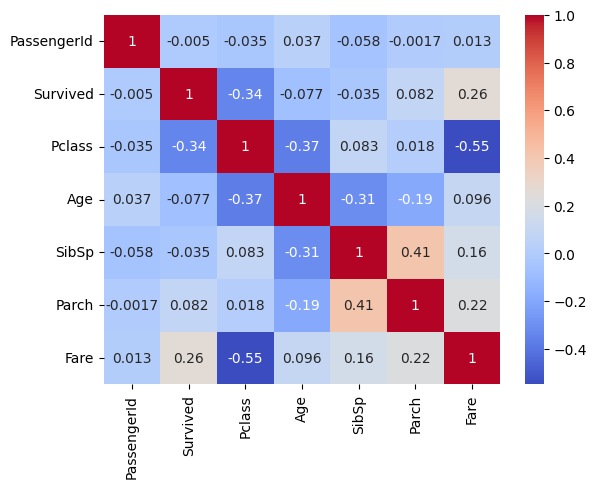

In [6]:
num_col = train_data.select_dtypes(include=['number'])

feature_corr = num_col.corr()
sns.heatmap(feature_corr, annot=True, cmap='coolwarm')
plt.show()

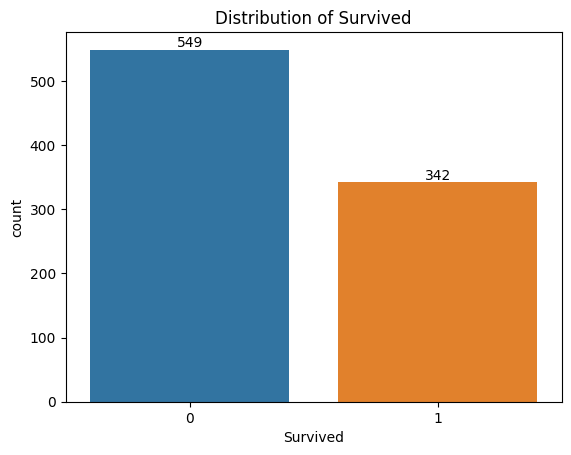

In [7]:
# Count plot for the 'Survived' column
age_plot = sns.countplot(x='Survived', data=train_data)
# Add numbers on top of the bars
for p in age_plot.patches:
    height = p.get_height()
    if height > 0:  # To avoid labeling bars with height 0
        age_plot.annotate(f'{int(height)}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 5), textcoords = 'offset points')
plt.title('Distribution of Survived')
plt.show()


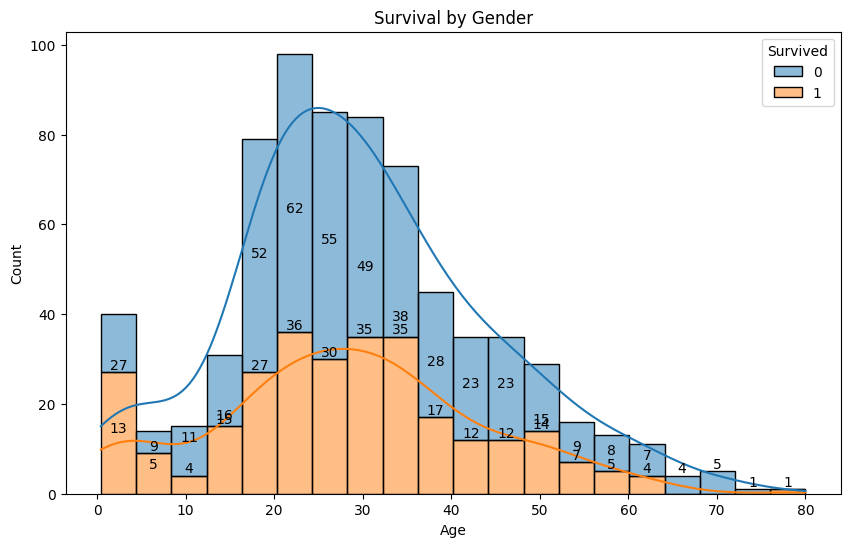

In [8]:
# Survival rates by gender
plt.figure(figsize=(10, 6))
age_plot = sns.histplot(data=train_data, x='Age', hue='Survived', multiple='stack', kde=True)

# Add numbers on top of the bars
for p in age_plot.patches:
    height = p.get_height()
    if height > 0:  # To avoid labeling bars with height 0
        age_plot.annotate(f'{int(height)}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha = 'center', va = 'center', 
                          xytext = (0, 5), textcoords = 'offset points')
        
        
plt.title('Survival by Gender')
plt.show()


## EDA

In [9]:
# check duplicates
train_data.duplicated().sum()


0

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


<Axes: >

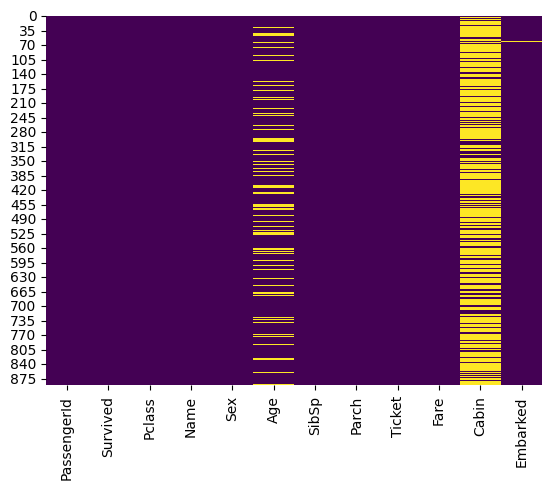

In [10]:
# check null values in train data
print(train_data.isnull().sum())
sns.heatmap(train_data.isnull(), cmap='viridis', cbar=False)

In [11]:
# check null values in test data
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [12]:
# your home work --> outlier / skewness

## Preprocessing & Feature engineer

In [13]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [14]:
########################################### 1. drop id column
train_data.drop('PassengerId', axis=1, inplace=True)
test_id_col = test_data['PassengerId']
test_data.drop('PassengerId', axis=1, inplace=True)

In [15]:
########################################## 2. Null value handling
# nulls in age
train_data['Age']= train_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
test_data['Age']= test_data.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Age and Fare Binning
train_data['Age_Bin']  = pd.cut(train_data['Age'], bins=[0, 16, 28, 40, 55, 100], labels=[0, 1, 2, 3, 4]).astype(int)
test_data['Age_Bin']  = pd.cut(test_data['Age'], bins=[0, 16, 28, 40, 55, 100], labels=[0, 1, 2, 3, 4]).astype(int)


# nulls in fare of test data
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)

#qcut ==> equal cut
train_data['Fare_Bin'] = pd.qcut(train_data['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)
test_data['Fare_Bin'] = pd.qcut(test_data['Fare'], 4, labels=[0, 1, 2, 3]).astype(int)

# nulls in cabin
train_data['Has_Cabin'] = train_data['Cabin'].notnull().astype(int)
test_data['Has_Cabin'] = test_data['Cabin'].notnull().astype(int)

train_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)

# nulls in Embarked
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)



print(train_data.isnull().sum().sum())
print(test_data.isnull().sum().sum())

0
0


In [16]:
########################################## 3. Feature engineering for Family size 
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch']
test_data['Family_Size'] = test_data['SibSp'] + test_data['Parch']
train_data['Is_Alone'] = (train_data['Family_Size'] == 0).astype(int)
test_data['Is_Alone'] = (test_data['Family_Size'] == 0).astype(int)


In [17]:
########################################## 4. Ticket prefix extraction and encoding
def extract_ticket_prefix(ticket):
    ticket = ticket.replace('/', '').replace('.', '')
    parts = ticket.split()
    return parts[0].upper() if len(parts) > 1 else 'None'

train_data['Ticket_Prefix'] = train_data['Ticket'].apply(extract_ticket_prefix)
test_data['Ticket_Prefix'] = test_data['Ticket'].apply(extract_ticket_prefix)

train_data['Ticket_Length'] = train_data['Ticket'].apply(lambda x: len(x))
test_data['Ticket_Length'] = test_data['Ticket'].apply(lambda x: len(x))

train_data['Is_Alphanumeric'] = train_data['Ticket'].apply(lambda x: 1 if x.isalnum() else 0)
test_data['Is_Alphanumeric'] = test_data['Ticket'].apply(lambda x: 1 if x.isalnum() else 0)

train_data.drop(['Ticket'], axis=1, inplace=True)
test_data.drop(['Ticket'], axis=1, inplace=True)

In [18]:
########################################## 5. Name column 
train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data['Title'] = test_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Group titles in both train and test sets
train_data['Title'] = train_data['Title'].replace(['Mlle', 'Ms', 'Lady'], 'Miss')
test_data['Title'] = test_data['Title'].replace(['Mlle', 'Ms', 'Lady'], 'Miss')
train_data['Title'] = train_data['Title'].replace(['Mme', 'Sir'], 'Mr')
test_data['Title'] = test_data['Title'].replace(['Mme', 'Sir'], 'Mr')

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Capt', 'Don', 'the Countess', 'Dona']
train_data['Title'] = train_data['Title'].replace(rare_titles, 'Other')
test_data['Title'] = test_data['Title'].replace(rare_titles, 'Other')

# Drop 'Name' from both datasets
train_data.drop('Name', axis=1, inplace=True)
test_data.drop('Name', axis=1, inplace=True)

In [19]:
########################################## 6. Encode categorical data (cat --> num)
train_data['Sex'] = train_data['Sex'].map({'male': 0, "female": 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, "female": 1})


# OneHotEncode 'Embarked'
# 001, 010, 100 --> 00, 01, 10
encoder = OneHotEncoder(sparse=False, drop='first')
embarked_encoded_train = encoder.fit_transform(train_data[['Embarked']])
embarked_encoded_test = encoder.transform(test_data[['Embarked']])


# Convert the encoded columns into DataFrame and concatenate
embarked_encoded_train_df = pd.DataFrame(embarked_encoded_train, columns=encoder.get_feature_names_out(['Embarked']))
embarked_encoded_test_df = pd.DataFrame(embarked_encoded_test, columns=encoder.get_feature_names_out(['Embarked']))

train_data = pd.concat([train_data, embarked_encoded_train_df], axis=1)
test_data = pd.concat([test_data, embarked_encoded_test_df], axis=1)

# Drop 'Embarked' column
train_data.drop('Embarked', axis=1, inplace=True)
test_data.drop('Embarked', axis=1, inplace=True)


# Encode 'Ticket_Prefix'
train_data['Ticket_Prefix'] = train_data['Ticket_Prefix'].astype('category').cat.codes
test_data['Ticket_Prefix'] = test_data['Ticket_Prefix'].astype('category').cat.codes


# Label encode 'Title' --> home work: repllace it with a better alternative
label_encoder = LabelEncoder()
train_data['Title'] = label_encoder.fit_transform(train_data['Title'])
test_data['Title'] = label_encoder.transform(test_data['Title'])


In [20]:
 ########################################## 7. Prepare data for model training
X = train_data.drop('Survived', axis=1)  # Drop the target column
y = train_data['Survived']  # Target variable (what we are predicting)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:
########################################## 8. Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data, and transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Also scale the test_data (which we will use for predictions)
test_data_scaled = scaler.transform(test_data)

In [22]:
 ########################################## 9. Initialize the XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=10000,
                             max_depth=4,
                             min_child_weight=2,
                             gamma=0.9,                        
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective='binary:logistic',
                             nthread=-1,
                             scale_pos_weight=1)

# Fit the model on the training data
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test_scaled)


# Evaluate the model
# Display a detailed classification report
print(classification_report(y_test, y_pred))

# Display confusion matrix
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.85      0.83       105
           1       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

[[89 16]
 [21 53]]


In [23]:
 ########################################## 10. Prepare submission file
test_predictions = xgb_model.predict(test_data_scaled)

# Since PassengerId was not dropped from test_data, we retrieve it from the original test set
output = pd.DataFrame({'PassengerId': pd.read_csv('/kaggle/input/titanic/test.csv')['PassengerId'], 
                       'Survived': test_predictions})

# Save the output for submission
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")


Your submission was successfully saved!
